In [76]:
import sys
import platform
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
from multiprocessing import Pool
from tqdm import tqdm

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

#hydroAI libs
import HydroAI.Data as hData
import HydroAI.Plot as hPlot

In [22]:
data_path = cpuserver_data_FP+'/WORK/DATASETS/GLOBAL/CMIP6/0. OVERALL/DATA/'
file_list = hData.get_file_list(data_path, 'nc')
print(file_list)

['/Users/hyunglokkim/cpuserver_data/WORK/DATASETS/GLOBAL/CMIP6/0. OVERALL/DATA/CMIP6_HIST_r1i1p1f1_1.00_005D_1970_2014.nc', '/Users/hyunglokkim/cpuserver_data/WORK/DATASETS/GLOBAL/CMIP6/0. OVERALL/DATA/CMIP6_SSP126_r1i1p1f1_1.00_005D_2016_2100.nc', '/Users/hyunglokkim/cpuserver_data/WORK/DATASETS/GLOBAL/CMIP6/0. OVERALL/DATA/CMIP6_SSP245_r1i1p1f1_1.00_005D_2016_2100.nc', '/Users/hyunglokkim/cpuserver_data/WORK/DATASETS/GLOBAL/CMIP6/0. OVERALL/DATA/CMIP6_SSP585_r1i1p1f1_1.00_005D_2016_2100.nc']


In [46]:
hData.get_nc_variable_names_units(file_list[0]);
lai_detrend = hData.get_variable_from_nc(file_list[0], 'lai_detrend')
lat = hData.get_variable_from_nc(file_list[0], 'lat')
lon = hData.get_variable_from_nc(file_list[0], 'lon')
lon, lat = np.meshgrid(lon, lat)

print(lai_detrend.shape)
lai_detrend = np.transpose(lai_detrend, (2, 1, 0))
print(lai_detrend.shape)

+--------------+----------------------------------------------------------+-----------------------+
| Name         | Long Name                                                | Units                 |
+==============+==========================================================+=======================+
| lat          | latitude                                                 | degrees_north         |
+--------------+----------------------------------------------------------+-----------------------+
| lon          | longitude                                                | degrees_east          |
+--------------+----------------------------------------------------------+-----------------------+
| time         | time                                                     | days since 0000-01-01 |
+--------------+----------------------------------------------------------+-----------------------+
| mrso_prctile | Ensemble Mean of Total Soil Moisture Percentile for HIST | %                     |


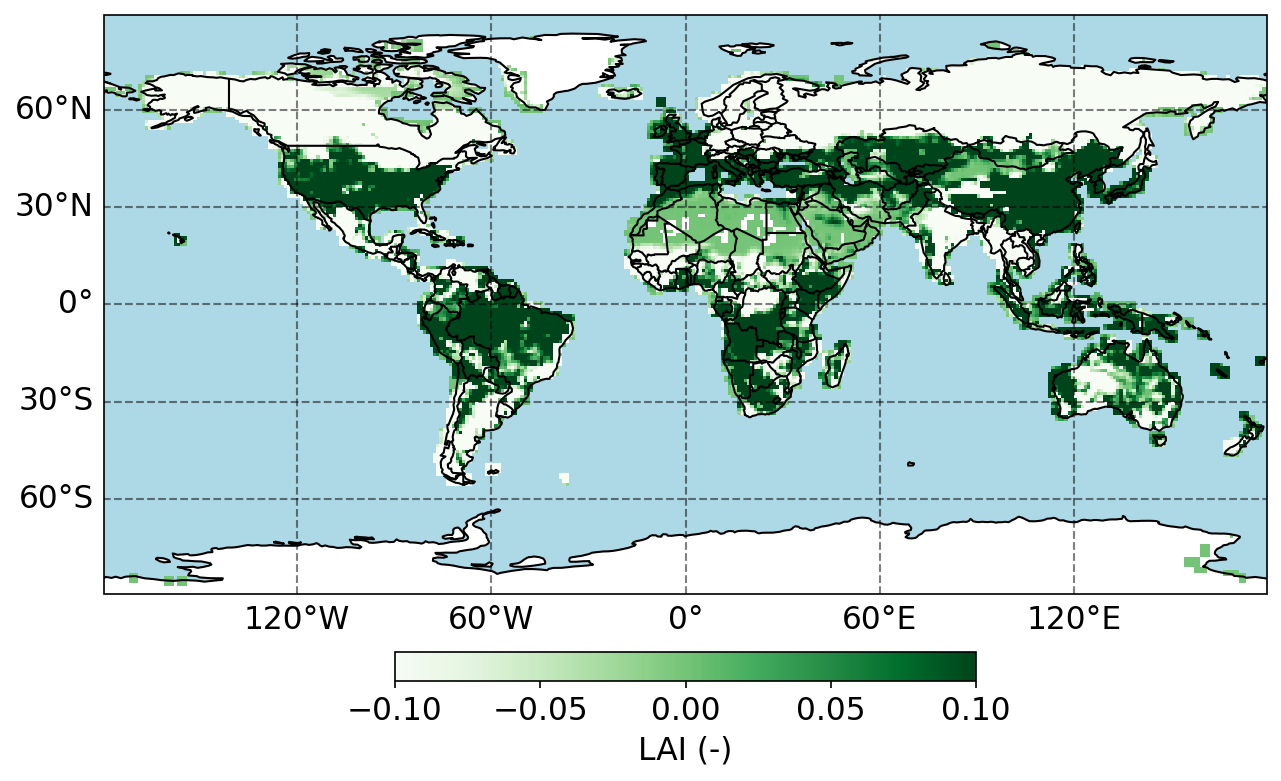

In [50]:
target = lai_detrend[:,:,100]
hPlot.plot_map(lon, lat, target, np.min(target), np.max(target), plot_title='lai detrend', label_title='LAI (-)', cmap='Greens', projection='PlateCarree');

(180, 360, 364) (180, 360, 364)


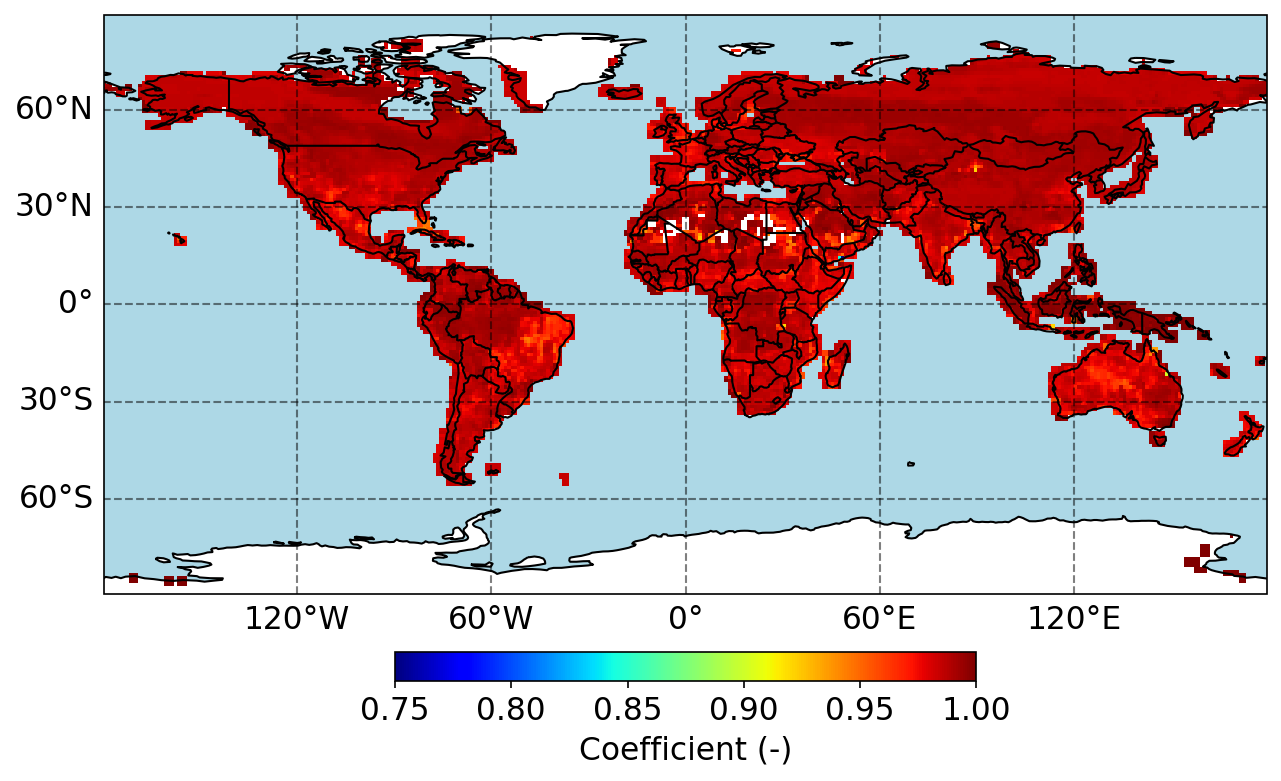

In [65]:
def critslowdown(data, win_size, lag_size, cor_type):
    # Computing Lag Auto-Correlation (LAC)
    lac = np.full(len(data), np.nan)

    d1 = data[t-win_size+lag_size:t]
    d2 = data[t-win_size:t-lag_size] 
    
    for t in range(win_size + lag_size, len(data)):
        if cor_type == 'Pearson':
            lac[t] = pearsonr(d1, d2)[0]
        elif cor_type == 'Spearman':
            lac[t] = spearmanr(d1, d2)[0]
        elif cor_type == 'Kendall':
            lac[t] = kendalltau(d1,d2)[0]
    
    return lac

def pearson_3d(d1, d2):
    # Step 1: Center the data (subtract the mean along the z-axis)
    mean_d1 = np.mean(d1, axis=2, keepdims=True)
    mean_d2 = np.mean(d2, axis=2, keepdims=True)
    d1_centered = d1 - mean_d1
    d2_centered = d2 - mean_d2
    
    # Step 2: Calculate the covariance between x1 and x2 along the z-axis
    covariance = np.einsum('ijk,ijk->ij', d1_centered, d2_centered)
    
    # Step 3: Calculate the standard deviations of x1 and x2 along the z-axis
    std_d1 = np.sqrt(np.einsum('ijk,ijk->ij', d1_centered, d1_centered))
    std_d2 = np.sqrt(np.einsum('ijk,ijk->ij', d2_centered, d2_centered))
    
    # Step 4: Calculate the Pearson correlation coefficients
    pearson_corrs = covariance / (std_d1 * std_d2)

    return pearson_corrs

data1 = np.random.random((100,100,100)) #lat, lon, time
data2 = np.random.random((100,100,100))


def generate_win_lag_data(data, t, win_size, lag_size):
    d1 = data[:, :, t-win_size+lag_size:t]
    d2 = data[:, :, t-win_size:t-lag_size]

    return d1, d2


# code example
win_size = 365
lag_size = 1
t = 365
d1, d2 = generate_win_lag_data(lai_detrend, t, win_size, lag_size)
lac_p = pearson_3d(d1,d2)
target = lac_p
hPlot.plot_map(lon, lat, target, np.nanmin(target), np.nanmax(target), plot_title='LAC_Pearson', label_title='Coefficient (-)', cmap='jet', projection='PlateCarree');

In [81]:
# without parallel
win_size = 365
lag_size = 1
data = lai_detrend
LAC_p = np.full((data.shape[0], data.shape[1], data.shape[2]-win_size), np.nan)

i = 0
for t in tqdm(range(win_size, data.shape[2])):
    d1, d2 = generate_win_lag_data(data, t, win_size, lag_size)
    lac_p = pearson_3d(d1,d2)
    LAC_p[:,:,i] = lac_p
    i += 1

 39%|████████████████████████████████████████████████▍                                                                          | 1149/2920 [01:31<02:20, 12.61it/s]


KeyboardInterrupt: 

In [ ]:
# with parallel
from multiprocessing import Pool, cpu_count

# data
win_size = 365
lag_size = 1
data = lai_detrend

# Initialize the result array
LAC_p = np.full((data.shape[0], data.shape[1], data.shape[2] - win_size), np.nan)

# Function to process a single time step
def process_time_step(t):
    d1, d2 = generate_win_lag_data(data, t, win_size, lag_size)
    return pearson_3d(d1, d2)

# Parallel execution
if __name__ == '__main__':
    # Define the range of time steps to process
    time_steps = range(win_size, data.shape[2])
    
    # Use all available CPU cores
    num_cores = cpu_count()
    
    with Pool(num_cores) as pool:
        # Map the process_time_step function to each time step in parallel
        results = list(tqdm(pool.imap(process_time_step, time_steps), total=len(time_steps)))
    
    # Fill LAC_p with the results
    for i, lac_p in enumerate(results):
        LAC_p[:, :, i] = lac_p

Process SpawnPoolWorker-1:
Process SpawnPoolWorker-2:
Process SpawnPoolWorker-3:
Process SpawnPoolWorker-4:
Process SpawnPoolWorker-5:
Process SpawnPoolWorker-6:
Process SpawnPoolWorker-7:
Process SpawnPoolWorker-8:
Process SpawnPoolWorker-9:
Process SpawnPoolWorker-10:
Process SpawnPoolWorker-11:
Process SpawnPoolWorker-12:
Process SpawnPoolWorker-13:
Process SpawnPoolWorker-14:
Process SpawnPoolWorker-15:
Process SpawnPoolWorker-16:
Process SpawnPoolWorker-17:
Process SpawnPoolWorker-19:
Process SpawnPoolWorker-18:
Process SpawnPoolWorker-20:
Process SpawnPoolWorker-21:
  0%|                                                                                                                                      | 0/2920 [00:00<?, ?it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (m

In [30]:
# Assuming x1 and x2 are your input data arrays with shape (x, y, z)

x1 = np.random.random((100,100,1000))
x2 = np.random.random((100,100,1000))
x, y, z = x1.shape

def pearson_3d(d1, d2):
    # Step 1: Center the data (subtract the mean along the z-axis)
    mean_x1 = np.mean(d1, axis=2, keepdims=True)
    mean_x2 = np.mean(d2, axis=2, keepdims=True)
    x1_centered = x1 - mean_x1
    x2_centered = x2 - mean_x2
    
    # Step 2: Calculate the covariance between x1 and x2 along the z-axis
    covariance = np.einsum('ijk,ijk->ij', x1_centered, x2_centered)
    
    # Step 3: Calculate the standard deviations of x1 and x2 along the z-axis
    std_x1 = np.sqrt(np.einsum('ijk,ijk->ij', x1_centered, x1_centered))
    std_x2 = np.sqrt(np.einsum('ijk,ijk->ij', x2_centered, x2_centered))
    
    # Step 4: Calculate the Pearson correlation coefficients
    pearson_corrs = covariance / (std_x1 * std_x2)

    return pearson_corrs

In [ ]:

def critslowdown(data, win_size, lag_size, cor_type):
    # Computing Lag Auto-Correlation (LAC)
    lac = np.full(len(data), np.nan)
    
    for t in range(win_size + lag_size, len(data)):
        if cor_type == 'Pearson':
            lac[t] = pearsonr(data[t-win_size+lag_size:t], data[t-win_size:t-lag_size])[0]
        elif cor_type == 'Spearman':
            lac[t] = spearmanr(data[t-win_size+lag_size:t], data[t-win_size:t-lag_size])[0]
        elif cor_type == 'Kendall':
            lac[t] = kendalltau(data[t-win_size+lag_size:t], data[t-win_size:t-lag_size])[0]
    
    return lac

def process_pixel(data_2d, npix, win_size, lag_size, cor_type, time):
    if np.count_nonzero(~np.isnan(data_2d[:, npix])) == 0:
        return np.full(time, np.nan)
    else:
        return critslowdown(data_2d[:, npix], win_size, lag_size, cor_type)

def critslowdown3(data, win_size, lag_size, cor_type, num_cores=None):
    lat, lon, time = data.shape
    data_2d = data.reshape((lat * lon, time)).T
    
    if num_cores is None:
        num_cores = cpu_count()  # Use all available cores if not specified

    with Pool(num_cores) as pool:
        lac_2d = pool.starmap(process_pixel, [(data_2d, npix, win_size, lag_size, cor_type, time) for npix in range(data_2d.shape[1])])
    
    lac_2d = np.array(lac_2d).T
    lac = lac_2d.reshape((time, lat, lon)).transpose((1, 2, 0))
    
    return lac

# Example usage:
DATA = np.random.rand(10, 10, 100)  # Example 3D data array (LAT, LON, TIME)
WIN_SIZE = 5
LAG_SIZE = 1
COR_TYPE = 'Pearson'
NUM_CORES = 4  # Specify the number of cores you want to use
LAC = critslowdown3(DATA, WIN_SIZE, LAG_SIZE, COR_TYPE, num_cores=NUM_CORES)


Process SpawnPoolWorker-142:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/hydroai/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/miniconda3/envs/hydroai/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/miniconda3/envs/hydroai/lib/python3.12/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/miniconda3/envs/hydroai/lib/python3.12/multiprocessing/queues.py", line 389, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'process_pixel' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>
Process SpawnPoolWorker-143:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/hydroai/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/miniconda3/envs/hydroai/lib/python3.12/multiproce